## Setup

In [726]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset

from models.unet_model import UNET

import segmentation_models_pytorch as smp

In [727]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

# Splitting into training and validation
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)

In [751]:
# Creating the dataset
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps, y_train_fps, augmentation=train_augmentation, preprocessing=preprocessing_fn)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 16,num_workers=4,pin_memory=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size= 16,num_workers=4,pin_memory=True,shuffle=False)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [752]:
import numpy as np
np.unique(mask)

array([0, 1])

In [753]:
import importlib.readers
from segmentation.show import *
import segmentation.constants
importlib.reload(segmentation.constants)
from segmentation.constants import VisualisationConstants

image, mask, heatmap = train_dataset[1]
mask = colorise_mask(mask, palette=VisualisationConstants.palette)
visualise_data(image = image, heatmap = heatmap, mask = mask)

ValueError: not enough values to unpack (expected 3, got 2)

In [755]:
model = UNET(4, 2)
model_utils.load_checkpoint('/Users/georgeboutselis/Downloads/final_model-14.pth',model)

=> Loading checkpoint from /Users/georgeboutselis/Downloads/final_model-14.pth


In [618]:
image.shape

(3, 256, 416)

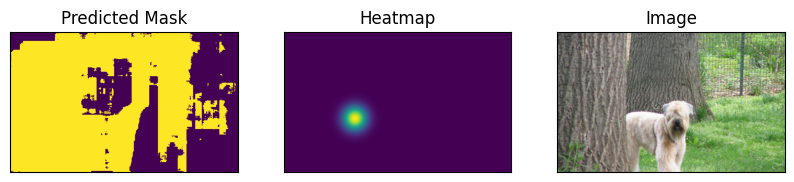

In [767]:
input, mask = train_dataset [2]
heatmap = input.numpy()[-1, :, :].copy()
image = input[:-1, :, :]
model.eval().double()
predict = model(input.double().unsqueeze(0))
predict_mask = np.argmax(predict.detach().numpy(), axis = 1)
visualise_data(predicted_mask = predict_mask.squeeze(0), heatmap = heatmap, image = image)

In [749]:
from segmentation.utils import traininglog

In [750]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    '''
    One epoch of training
    '''
    model.train()
    loop = tqdm(loader)
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE, dtype=torch.float32)
        targets = targets.long().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.autocast(device_type=DEVICE, dtype=torch.float16):
            targets = targets.squeeze(1)  # (N, H, W)
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader)
    return avg_loss

def validate_fn(loader, model, loss_fn):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device=DEVICE, dtype=torch.float32)
            targets = targets.long().unsqueeze(1).to(device=DEVICE)
            with torch.autocast(device_type=DEVICE, dtype=torch.float16):
                # squeeze targets to get shape (N, H, W)
                predictions = model(data)
                loss = loss_fn(predictions, targets.squeeze(1))
            total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    model.train()  # set model back to training mode
    return avg_loss


def train_and_evaluate(model, optimizer, train_loader, valid_loader, loss_fn, num_epochs):
    '''
    Trains the model for a given set of hyperparameters and evaluates it.
    '''
    scaler = amp.GradScaler()
    best_val_loss = 100

    for epoch in range(num_epochs):
        # ... training loop ....
        train_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        checkpoint = {'state_dict': model.state_dict()}

        val_loss = validate_fn(valid_loader, model, loss_fn)
        print(f'validation loss: {val_loss}')

        # Saving if the validation loss is better
        if val_loss < best_val_loss:
            model_utils.save_checkpoint(checkpoint)
            best_val_loss = val_loss

        traininglog.log_training(epoch = epoch, train_loss = train_loss, val_loss = val_loss)


In [ ]:
model = UNET(in_channels=4, out_channels=2).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
#dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


train_and_evaluate(model=model,
                   optimizer=optimizer,
                   train_loader=train_loader,
                   valid_loader=val_loader,
                   loss_fn = loss_fn,
                   num_epochs=100
                   )

/opt/miniconda3/envs/cv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
  0%|          | 0/1 [00:17<?, ?it/s]

: 